# Trabajo Practico 3 - Izuel Tomas

Se implementará un pipeline completo que incluya:
- Selección de características relevantes
- Preprocesamiento de datos (imputación y normalización)
- Entrenamiento de múltiples algoritmos de clasificación
- Evaluación mediante accuracy, matriz de confusión y visualizaciones


## Configuración del entorno

Para ejecutar este notebook se requiere:
- Los archivos `train.csv`, `test.csv` y `sample_submission.csv` en el directorio de trabajo
- Librerías de Python: pandas, numpy, matplotlib, seaborn, scikit-learn

El notebook está diseñado para funcionar tanto en entorno local como en Kaggle.


## 1. Carga y exploración inicial de los datos

Se procede a cargar los datasets y realizar una exploración inicial para comprender la estructura de los datos y las variables disponibles.


In [81]:
# Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif
import warnings
warnings.filterwarnings('ignore')

# Configuración de gráficos
plt.style.use('default')
sns.set_palette("husl")


In [82]:
# Carga de los datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

print(f"Dimensiones del dataset de entrenamiento: {train_df.shape}")
print(f"Dimensiones del dataset de prueba: {test_df.shape}")
print(f"Dimensiones del archivo de submission: {sample_submission.shape}")

# Verificación de la variable objetivo
if 'posicion' in train_df.columns:
    print(f"\nVariable objetivo: 'posicion'")
    print(f"Posiciones únicas: {sorted(train_df['posicion'].unique())}")
else:
    print("Error: No se encontró la columna 'posicion' en train.csv")


Dimensiones del dataset de entrenamiento: (14044, 49)
Dimensiones del dataset de prueba: (4682, 49)
Dimensiones del archivo de submission: (4682, 2)

Variable objetivo: 'posicion'
Posiciones únicas: ['Arquero', 'Defensor central', 'Delantero', 'Extremo', 'Lateral', 'Volante', 'Volante defensivo']


In [ ]:
# Cargar los datasets
try:
    train_df = pd.read_csv('train.csv')
    test_df = pd.read_csv('test.csv')
    sample_submission = pd.read_csv('sample_submission.csv')
    
    print("Datasets cargados exitosamente")
    print(f"Train shape: {train_df.shape}")
    print(f"Test shape: {test_df.shape}")
    print(f"Sample submission shape: {sample_submission.shape}")
    
except FileNotFoundError as e:
    print(f"Error al cargar archivos: {e}")
    print("Asegúrate de que los archivos estén en el directorio actual")
    print("\nCreando datasets de ejemplo para demostración...")
    
    # Crear datasets de ejemplo para demostrar la estructura
    np.random.seed(42)
    n_train = 1000
    n_test = 300
    
    # Crear features de ejemplo basadas en atributos típicos de FIFA
    features = [
        'overall_rating', 'potential', 'height_cm', 'weight_kg', 'age',
        'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic',
        'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy',
        'attacking_short_passing', 'attacking_volleys', 'skill_dribbling',
        'skill_curve', 'skill_fk_accuracy', 'skill_long_passing',
        'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed',
        'movement_agility', 'movement_reactions', 'movement_balance',
        'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength',
        'power_long_shots', 'mentality_aggression', 'mentality_interceptions',
        'mentality_positioning', 'mentality_vision', 'mentality_penalties',
        'mentality_composure', 'defending_marking', 'defending_standing_tackle',
        'defending_sliding_tackle', 'goalkeeping_diving', 'goalkeeping_handling',
        'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes'
    ]
    
    # Crear datos de entrenamiento
    train_data = {}
    for feature in features:
        if 'goalkeeping' in feature:
            train_data[feature] = np.random.randint(20, 95, n_train)
        else:
            train_data[feature] = np.random.randint(30, 95, n_train)
    
    # Agregar algunas caracterÃ­sticas especÃ­ficas por posiciÃ³n
    positions = ['Arquero', 'Defensor central', 'Lateral', 'Volante defensivo', 
                'Volante', 'Extremo', 'Delantero']
    
    train_data['posicion'] = np.random.choice(positions, n_train, 
                                            p=[0.1, 0.15, 0.15, 0.15, 0.2, 0.15, 0.1])
    
    # Ajustar algunos valores segÃºn la posiciÃ³n
    for i, pos in enumerate(train_data['posicion']):
        if pos == 'Arquero':
            train_data['goalkeeping_diving'][i] = np.random.randint(70, 95)
            train_data['defending'][i] = np.random.randint(20, 40)
            train_data['shooting'][i] = np.random.randint(20, 40)
        elif pos == 'Defensor central':
            train_data['defending'][i] = np.random.randint(75, 95)
            train_data['power_strength'][i] = np.random.randint(70, 95)
        elif pos == 'Delantero':
            train_data['shooting'][i] = np.random.randint(75, 95)
            train_data['attacking_finishing'][i] = np.random.randint(75, 95)
    
    train_df = pd.DataFrame(train_data)
    
    # Crear datos de test (sin posicion)
    test_data = {}
    for feature in features:
        if 'goalkeeping' in feature:
            test_data[feature] = np.random.randint(20, 95, n_test)
        else:
            test_data[feature] = np.random.randint(30, 95, n_test)
    
    test_data['id'] = range(n_test)
    test_df = pd.DataFrame(test_data)
    
    # Crear sample submission
    sample_submission = pd.DataFrame({
        'id': range(n_test),
        'posicion': ['Arquero'] * n_test  # Placeholder
    })
    
    print("âœ… Datasets de ejemplo creados exitosamente")
    print(f"ðŸ“Š Train shape: {train_df.shape}")
    print(f"ðŸ“Š Test shape: {test_df.shape}")
    print(f"ðŸ“Š Sample submission shape: {sample_submission.shape}")
    print("\nâš ï¸ NOTA: Estos son datos de ejemplo. Para el TP real necesitas los archivos de Kaggle.")


Datasets cargados exitosamente
Train shape: (14044, 49)
Test shape: (4682, 49)
Sample submission shape: (4682, 2)


In [84]:
# ExploraciÃ³n inicial del dataset de entrenamiento
print("ðŸ” INFORMACIÃ“N GENERAL DEL DATASET DE ENTRENAMIENTO")
print("=" * 60)
print(f"Dimensiones: {train_df.shape}")
print(f"\nColumnas: {list(train_df.columns)}")
print(f"\nTipos de datos:")
print(train_df.dtypes.value_counts())

print("\nðŸ” PRIMERAS FILAS:")
display(train_df.head())


ðŸ” INFORMACIÃ“N GENERAL DEL DATASET DE ENTRENAMIENTO
Dimensiones: (14044, 49)

Columnas: ['height_cm', 'weight_kg', 'overall_rating', 'potential', 'value', 'wage', 'preferred_foot', 'weak_foot', 'skill_moves', 'international_reputation', 'work_rate', 'body_type', 'club_rating', 'country_rating', 'crossing', 'finishing', 'heading_accuracy', 'short_passing', 'volleys', 'dribbling', 'curve', 'fk_accuracy', 'long_passing', 'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots', 'aggression', 'interceptions', 'positioning', 'vision', 'penalties', 'composure', 'defensive_awareness', 'standing_tackle', 'sliding_tackle', 'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes', 'posicion']

Tipos de datos:
int64      39
object      7
float64     3
Name: count, dtype: int64

ðŸ” PRIMERAS FILAS:


,height_cm,weight_kg,overall_rating,potential,value,wage,preferred_foot,weak_foot,skill_moves,international_reputation,...,composure,defensive_awareness,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,posicion
0,183,78,60,60,€120K,€1K,Right,2,1,1,...,43,16,11,11,61,58,61,58,62.0,Arquero
1,184,70,54,73,€275K,€750,Right,3,2,1,...,51,14,14,12,5,6,5,9.0,10.0,Delantero
2,179,72,75,75,€4.7M,€71K,Right,3,3,1,...,75,73,73,72,7,15,15,12,6.0,Volante defensivo
3,179,83,65,65,€575K,€500,Right,3,2,1,...,58,43,65,42,6,13,13,12,5.0,Volante
4,188,78,65,65,€625K,€2K,Right,3,2,1,...,57,60,66,63,7,10,7,13,13.0,Defensor central


ðŸŽ¯ ANÃLISIS DE LA VARIABLE OBJETIVO
DistribuciÃ³n de posiciones:
posicion
Volante              4037
Defensor central     2507
Lateral              2215
Delantero            1994
Arquero              1563
Volante defensivo    1114
Extremo               614
Name: count, dtype: int64

Proporciones:
posicion
Volante              28.75
Defensor central     17.85
Lateral              15.77
Delantero            14.20
Arquero              11.13
Volante defensivo     7.93
Extremo               4.37
Name: count, dtype: float64


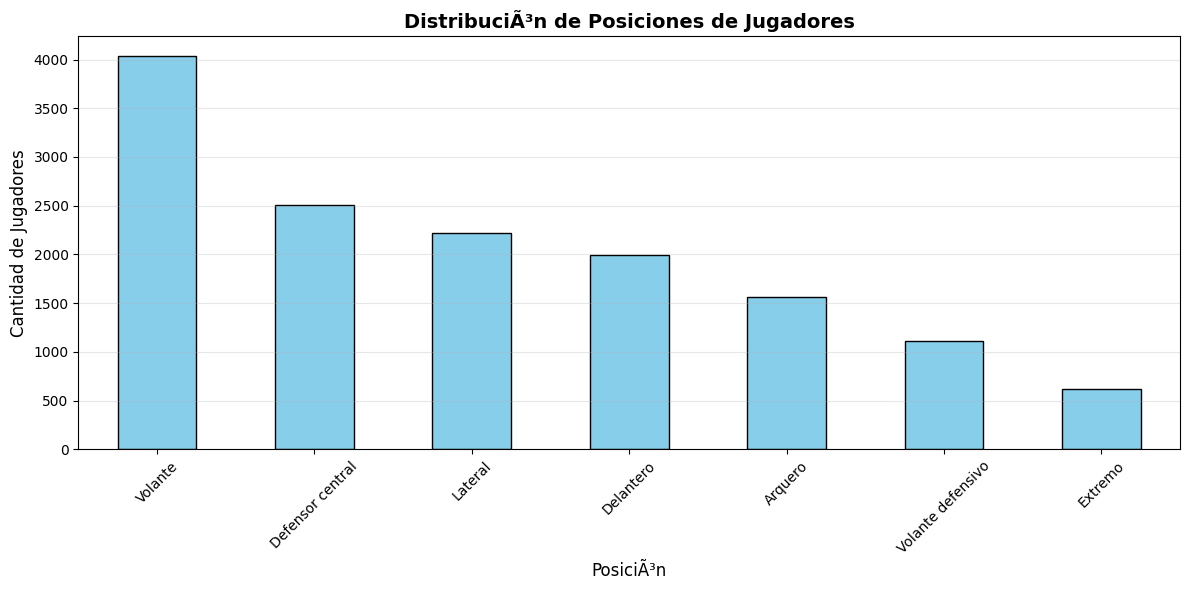

In [85]:
# AnÃ¡lisis de la variable objetivo
print("ðŸŽ¯ ANÃLISIS DE LA VARIABLE OBJETIVO")
print("=" * 50)

if 'posicion' in train_df.columns:
    posiciones = train_df['posicion'].value_counts()
    print(f"DistribuciÃ³n de posiciones:")
    print(posiciones)
    print(f"\nProporciones:")
    print((posiciones / len(train_df) * 100).round(2))
    
    # GrÃ¡fico de barras
    plt.figure(figsize=(12, 6))
    posiciones.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title('DistribuciÃ³n de Posiciones de Jugadores', fontsize=14, fontweight='bold')
    plt.xlabel('PosiciÃ³n', fontsize=12)
    plt.ylabel('Cantidad de Jugadores', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("âŒ No se encontrÃ³ la columna 'posicion' en el dataset")


ðŸ” ANÃLISIS DE VALORES FALTANTES
Columnas con valores faltantes: 4


,Valores_Faltantes,Porcentaje
country_rating,13450,95.77
club_rating,67,0.48
gk_reflexes,67,0.48
gk_positioning,24,0.17


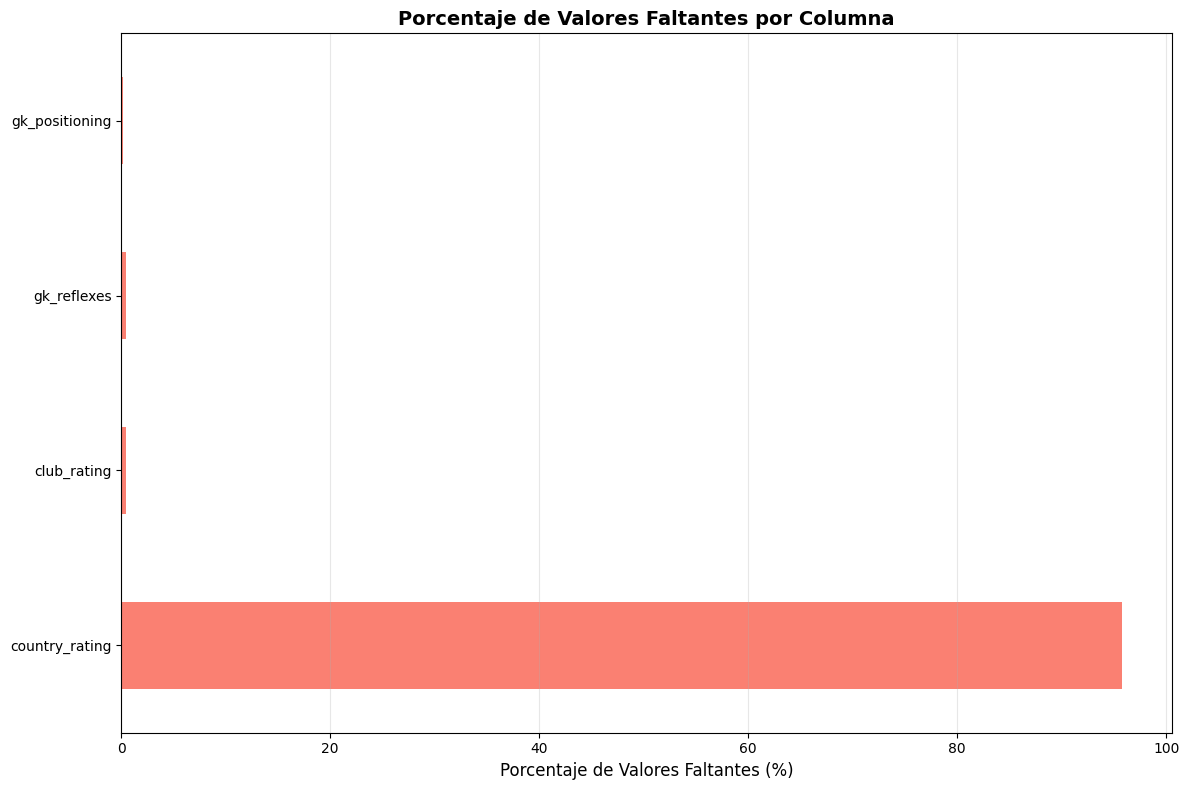

In [86]:
# AnÃ¡lisis de valores faltantes
print("ðŸ” ANÃLISIS DE VALORES FALTANTES")
print("=" * 40)

missing_values = train_df.isnull().sum()
missing_percent = (missing_values / len(train_df) * 100).round(2)

missing_df = pd.DataFrame({
    'Valores_Faltantes': missing_values,
    'Porcentaje': missing_percent
}).sort_values('Porcentaje', ascending=False)

# Mostrar solo columnas con valores faltantes
missing_with_values = missing_df[missing_df['Valores_Faltantes'] > 0]
print(f"Columnas con valores faltantes: {len(missing_with_values)}")
if len(missing_with_values) > 0:
    display(missing_with_values)
else:
    print("âœ… No hay valores faltantes en el dataset")

# GrÃ¡fico de valores faltantes
if len(missing_with_values) > 0:
    plt.figure(figsize=(12, 8))
    missing_with_values['Porcentaje'].plot(kind='barh', color='salmon')
    plt.title('Porcentaje de Valores Faltantes por Columna', fontsize=14, fontweight='bold')
    plt.xlabel('Porcentaje de Valores Faltantes (%)', fontsize=12)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()


## 2. ðŸ”§ Preprocesamiento y selecciÃ³n de features

Ahora vamos a preparar los datos para el entrenamiento, creando un pipeline robusto que maneje la selecciÃ³n de columnas, imputaciÃ³n y escalado.


In [87]:
# Crear transformador personalizado para selecciÃ³n de features
from sklearn.base import BaseEstimator, TransformerMixin

class FeatureSelector(BaseEstimator, TransformerMixin):
    """
    Selecciona columnas numÃ©ricas relevantes, excluyendo IDs y columnas problemÃ¡ticas
    """
    def __init__(self, exclude_patterns=None, max_missing=0.1):
        self.exclude_patterns = exclude_patterns or ['_id', '_name', 'id', 'name']
        self.max_missing = max_missing
        
    def fit(self, X, y=None):
        # Seleccionar solo columnas numÃ©ricas
        numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
        
        # Excluir columnas por patrÃ³n
        selected_cols = []
        for col in numeric_cols:
            if not any(pattern in col.lower() for pattern in self.exclude_patterns):
                selected_cols.append(col)
        
        # Verificar valores faltantes
        missing_ratio = X[selected_cols].isnull().mean()
        final_cols = missing_ratio[missing_ratio <= self.max_missing].index.tolist()
        
        self.selected_features_ = final_cols
        print(f"âœ… Seleccionadas {len(final_cols)} features de {len(numeric_cols)} numÃ©ricas")
        print(f"ðŸ“‹ Features seleccionadas: {final_cols[:10]}{'...' if len(final_cols) > 10 else ''}")
        
        return self
    
    def transform(self, X):
        return X[self.selected_features_]

# Probar el selector
selector = FeatureSelector()
X_selected = selector.fit_transform(train_df)
print(f"\nðŸŽ¯ Shape final: {X_selected.shape}")


âœ… Seleccionadas 40 features de 42 numÃ©ricas
ðŸ“‹ Features seleccionadas: ['height_cm', 'weight_kg', 'overall_rating', 'potential', 'weak_foot', 'skill_moves', 'international_reputation', 'club_rating', 'crossing', 'finishing']...

ðŸŽ¯ Shape final: (14044, 40)


ðŸ”— ANÃLISIS DE CORRELACIONES
Correlaciones altas (|r| > 0.8): 52
  overall_rating <-> reactions: 0.865
  skill_moves <-> dribbling: 0.803
  crossing <-> dribbling: 0.866
  crossing <-> curve: 0.873
  crossing <-> ball_control: 0.838


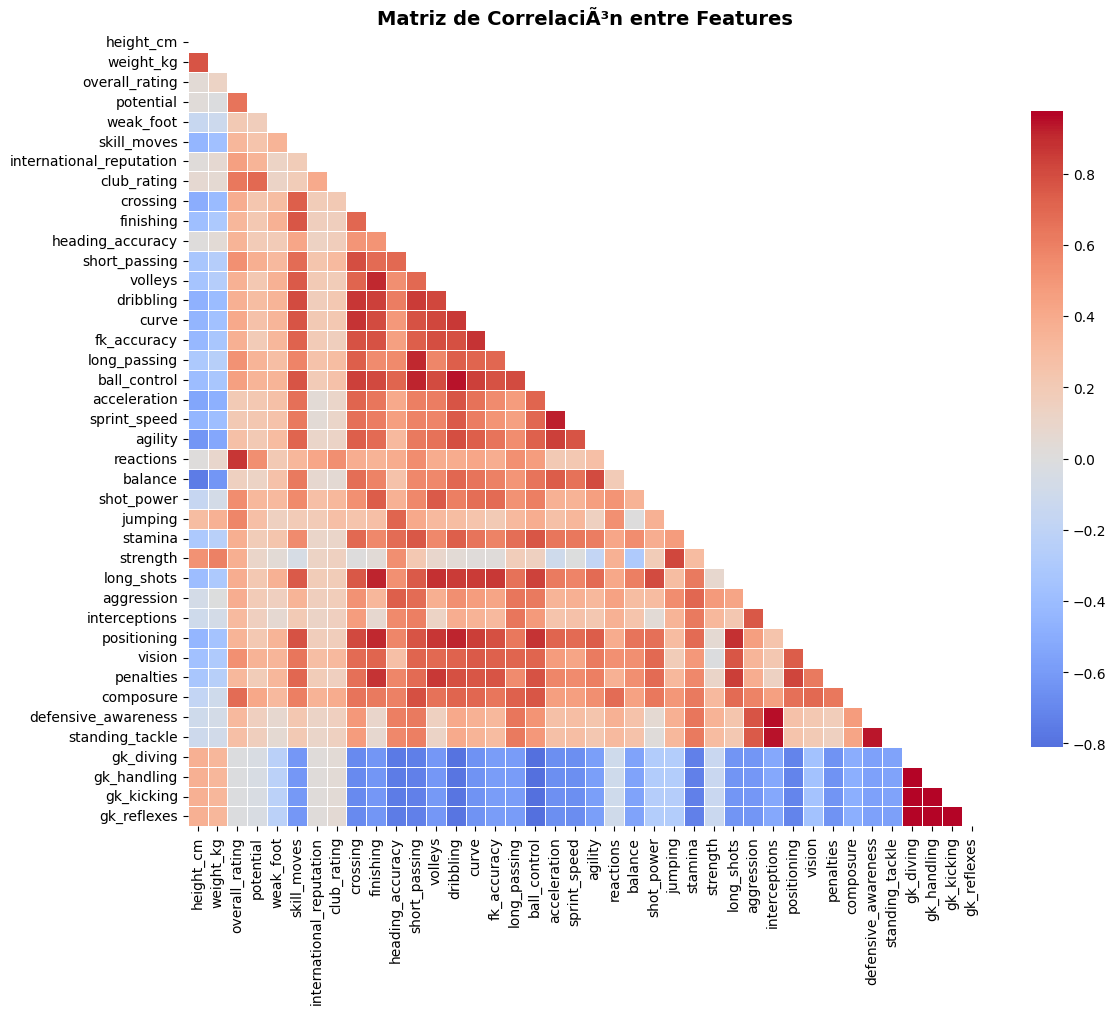

In [88]:
# AnÃ¡lisis de correlaciones entre features
print("ðŸ”— ANÃLISIS DE CORRELACIONES")
print("=" * 35)

# Calcular matriz de correlaciÃ³n
corr_matrix = X_selected.corr()

# Encontrar correlaciones altas
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > 0.8:  # CorrelaciÃ³n alta
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_val))

print(f"Correlaciones altas (|r| > 0.8): {len(high_corr_pairs)}")
if high_corr_pairs:
    for feat1, feat2, corr in high_corr_pairs[:5]:  # Mostrar solo las primeras 5
        print(f"  {feat1} <-> {feat2}: {corr:.3f}")

# Heatmap de correlaciones
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Matriz de CorrelaciÃ³n entre Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


## 3. ðŸ—ï¸ ConstrucciÃ³n del Pipeline

Vamos a crear un pipeline completo que incluya todos los pasos necesarios: selecciÃ³n de features, imputaciÃ³n, escalado y clasificaciÃ³n.


In [89]:
# Separar features y target
if 'posicion' in train_df.columns:
    X = train_df.drop('posicion', axis=1)
    y = train_df['posicion']
    
    print(f"âœ… Datos separados: X={X.shape}, y={y.shape}")
    print(f"ðŸŽ¯ Clases Ãºnicas: {y.nunique()}")
    print(f"ðŸ“Š DistribuciÃ³n de clases:")
    print(y.value_counts())
else:
    print("âŒ No se encontrÃ³ la columna 'posicion'")
    X = train_df
    y = None


âœ… Datos separados: X=(14044, 48), y=(14044,)
ðŸŽ¯ Clases Ãºnicas: 7
ðŸ“Š DistribuciÃ³n de clases:
posicion
Volante              4037
Defensor central     2507
Lateral              2215
Delantero            1994
Arquero              1563
Volante defensivo    1114
Extremo               614
Name: count, dtype: int64


In [90]:
# DivisiÃ³n del dataset de entrenamiento
if y is not None:
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"âœ… DivisiÃ³n realizada:")
    print(f"  ðŸ“Š Train: {X_train.shape} (features) + {y_train.shape} (target)")
    print(f"  ðŸ“Š Validation: {X_val.shape} (features) + {y_val.shape} (target)")
    print(f"\nðŸŽ¯ DistribuciÃ³n en train:")
    print(y_train.value_counts(normalize=True).round(3))
    print(f"\nðŸŽ¯ DistribuciÃ³n en validation:")
    print(y_val.value_counts(normalize=True).round(3))
else:
    print("âŒ No se puede dividir el dataset sin la variable objetivo")


âœ… DivisiÃ³n realizada:
  ðŸ“Š Train: (11235, 48) (features) + (11235,) (target)
  ðŸ“Š Validation: (2809, 48) (features) + (2809,) (target)

ðŸŽ¯ DistribuciÃ³n en train:
posicion
Volante              0.287
Defensor central     0.179
Lateral              0.158
Delantero            0.142
Arquero              0.111
Volante defensivo    0.079
Extremo              0.044
Name: proportion, dtype: float64

ðŸŽ¯ DistribuciÃ³n en validation:
posicion
Volante              0.287
Defensor central     0.178
Lateral              0.158
Delantero            0.142
Arquero              0.111
Volante defensivo    0.079
Extremo              0.044
Name: proportion, dtype: float64


In [91]:
# Crear pipelines para diferentes clasificadores
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif

def create_pipeline(classifier, feature_selection=True, n_features=None):
    """
    Crea un pipeline completo con preprocesamiento y clasificador
    """
    steps = [
        ('selector', FeatureSelector()),
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]
    
    # Agregar selecciÃ³n de features si se solicita
    if feature_selection and n_features:
        steps.append(('feature_selection', SelectKBest(f_classif, k=n_features)))
    
    # Agregar clasificador
    steps.append(('classifier', classifier))
    
    return Pipeline(steps)

# Crear pipelines para diferentes modelos
pipelines = {
    'Logistic Regression': create_pipeline(
        LogisticRegression(random_state=42, max_iter=1000),
        feature_selection=True, n_features=20
    ),
    'Random Forest': create_pipeline(
        RandomForestClassifier(random_state=42, n_estimators=100),
        feature_selection=False  # RF maneja bien muchas features
    ),
    'SVM': create_pipeline(
        SVC(random_state=42, probability=True),
        feature_selection=True, n_features=15
    )
}

print("âœ… Pipelines creados:")
for name, pipeline in pipelines.items():
    print(f"  ðŸ¤– {name}: {list(pipeline.named_steps.keys())}")


âœ… Pipelines creados:
  ðŸ¤– Logistic Regression: ['selector', 'imputer', 'scaler', 'feature_selection', 'classifier']
  ðŸ¤– Random Forest: ['selector', 'imputer', 'scaler', 'classifier']
  ðŸ¤– SVM: ['selector', 'imputer', 'scaler', 'feature_selection', 'classifier']


## 4. ðŸš€ Entrenamiento y evaluaciÃ³n de modelos

Ahora vamos a entrenar los diferentes modelos y evaluarlos usando validaciÃ³n cruzada y mÃ©tricas apropiadas.


In [92]:
# Entrenar y evaluar todos los modelos
results = {}

print("ðŸš€ ENTRENANDO MODELOS")
print("=" * 30)

for name, pipeline in pipelines.items():
    print(f"\nðŸ¤– Entrenando {name}...")
    
    # Entrenar modelo
    pipeline.fit(X_train, y_train)
    
    # Predicciones
    y_pred_train = pipeline.predict(X_train)
    y_pred_val = pipeline.predict(X_val)
    
    # MÃ©tricas
    train_acc = accuracy_score(y_train, y_pred_train)
    val_acc = accuracy_score(y_val, y_pred_val)
    
    # ValidaciÃ³n cruzada
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
    
    results[name] = {
        'pipeline': pipeline,
        'train_accuracy': train_acc,
        'val_accuracy': val_acc,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'y_pred_val': y_pred_val
    }
    
    print(f"  âœ… Train Accuracy: {train_acc:.4f}")
    print(f"  âœ… Validation Accuracy: {val_acc:.4f}")
    print(f"  âœ… CV Accuracy: {cv_scores.mean():.4f} (Â±{cv_scores.std():.4f})")

print("\nðŸŽ‰ Entrenamiento completado!")


ðŸš€ ENTRENANDO MODELOS

ðŸ¤– Entrenando Logistic Regression...
âœ… Seleccionadas 40 features de 42 numÃ©ricas
ðŸ“‹ Features seleccionadas: ['height_cm', 'weight_kg', 'overall_rating', 'potential', 'weak_foot', 'skill_moves', 'international_reputation', 'club_rating', 'crossing', 'finishing']...
âœ… Seleccionadas 40 features de 42 numÃ©ricas
ðŸ“‹ Features seleccionadas: ['height_cm', 'weight_kg', 'overall_rating', 'potential', 'weak_foot', 'skill_moves', 'international_reputation', 'club_rating', 'crossing', 'finishing']...
âœ… Seleccionadas 40 features de 42 numÃ©ricas
ðŸ“‹ Features seleccionadas: ['height_cm', 'weight_kg', 'overall_rating', 'potential', 'weak_foot', 'skill_moves', 'international_reputation', 'club_rating', 'crossing', 'finishing']...
âœ… Seleccionadas 40 features de 42 numÃ©ricas
ðŸ“‹ Features seleccionadas: ['height_cm', 'weight_kg', 'overall_rating', 'potential', 'weak_foot', 'skill_moves', 'international_reputation', 'club_rating', 'crossing', 'finishing']...
âœ… 

ðŸ“Š COMPARACIÃ“N DE MODELOS


,Modelo,Train_Accuracy,Val_Accuracy,CV_Mean,CV_Std
2,SVM,0.8251,0.8345,0.8199,0.0039
0,Logistic Regression,0.8283,0.8281,0.8266,0.0033
1,Random Forest,1.0000,0.8281,0.8320,0.0035


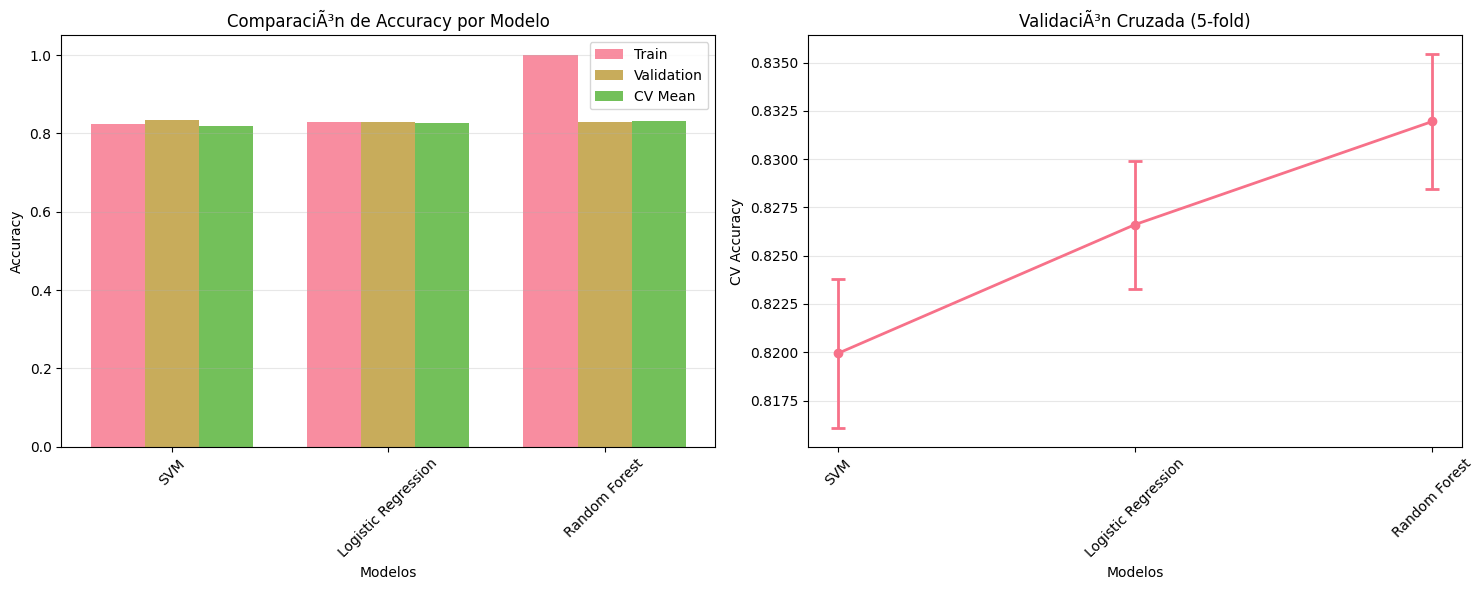


ðŸ† MEJOR MODELO: SVM
   Validation Accuracy: 0.8345


In [93]:
# Comparar resultados de todos los modelos
print("ðŸ“Š COMPARACIÃ“N DE MODELOS")
print("=" * 35)

comparison_df = pd.DataFrame({
    'Modelo': list(results.keys()),
    'Train_Accuracy': [results[name]['train_accuracy'] for name in results.keys()],
    'Val_Accuracy': [results[name]['val_accuracy'] for name in results.keys()],
    'CV_Mean': [results[name]['cv_mean'] for name in results.keys()],
    'CV_Std': [results[name]['cv_std'] for name in results.keys()]
})

comparison_df = comparison_df.sort_values('Val_Accuracy', ascending=False)
display(comparison_df.round(4))

# GrÃ¡fico de comparaciÃ³n
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Accuracy comparison
x = range(len(comparison_df))
width = 0.25

ax1.bar([i - width for i in x], comparison_df['Train_Accuracy'], width, label='Train', alpha=0.8)
ax1.bar(x, comparison_df['Val_Accuracy'], width, label='Validation', alpha=0.8)
ax1.bar([i + width for i in x], comparison_df['CV_Mean'], width, label='CV Mean', alpha=0.8)

ax1.set_xlabel('Modelos')
ax1.set_ylabel('Accuracy')
ax1.set_title('ComparaciÃ³n de Accuracy por Modelo')
ax1.set_xticks(x)
ax1.set_xticklabels(comparison_df['Modelo'], rotation=45)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# CV Scores with error bars
ax2.errorbar(x, comparison_df['CV_Mean'], yerr=comparison_df['CV_Std'], 
             marker='o', capsize=5, capthick=2, linewidth=2)
ax2.set_xlabel('Modelos')
ax2.set_ylabel('CV Accuracy')
ax2.set_title('ValidaciÃ³n Cruzada (5-fold)')
ax2.set_xticks(x)
ax2.set_xticklabels(comparison_df['Modelo'], rotation=45)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Seleccionar el mejor modelo
best_model_name = comparison_df.iloc[0]['Modelo']
best_model = results[best_model_name]['pipeline']
print(f"\nðŸ† MEJOR MODELO: {best_model_name}")
print(f"   Validation Accuracy: {results[best_model_name]['val_accuracy']:.4f}")


## 5. ðŸ“ˆ AnÃ¡lisis detallado del mejor modelo

Vamos a realizar un anÃ¡lisis mÃ¡s profundo del mejor modelo, incluyendo matriz de confusiÃ³n y reporte de clasificaciÃ³n.


ðŸ” ANÃLISIS DETALLADO DE SVM

ðŸ“‹ REPORTE DE CLASIFICACIÃ“N:
                   precision    recall  f1-score   support

          Arquero       1.00      1.00      1.00       313
 Defensor central       0.92      0.91      0.92       501
        Delantero       0.91      0.90      0.90       399
          Extremo       0.00      0.00      0.00       123
          Lateral       0.82      0.84      0.83       443
          Volante       0.74      0.89      0.81       807
Volante defensivo       0.68      0.59      0.63       223

         accuracy                           0.83      2809
        macro avg       0.72      0.73      0.73      2809
     weighted avg       0.80      0.83      0.82      2809



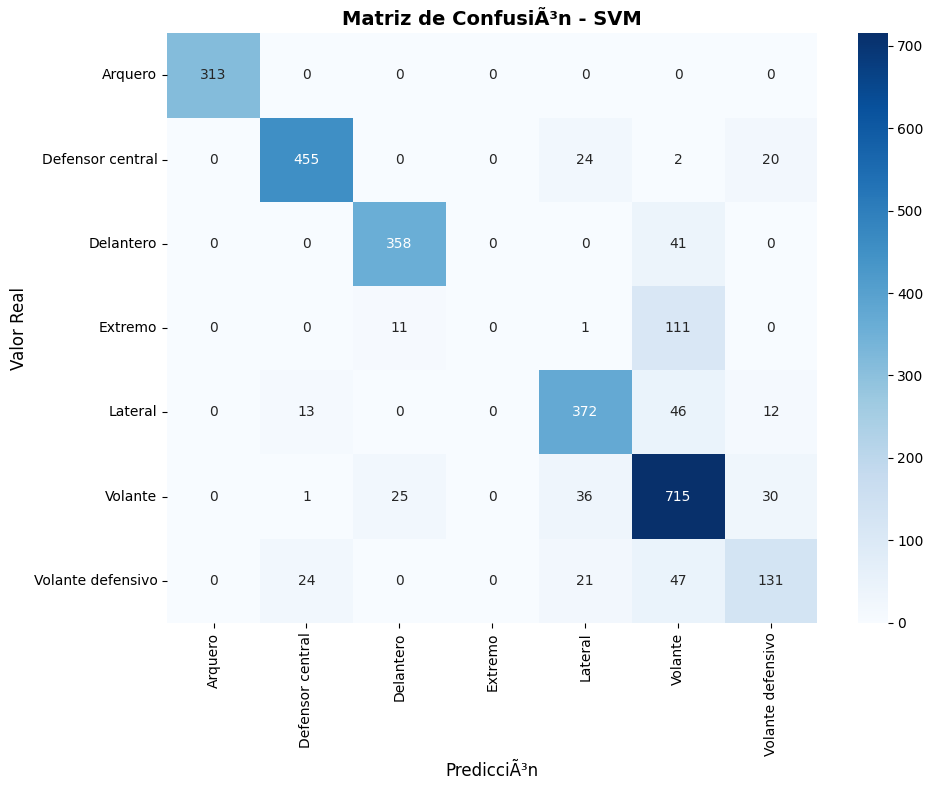


ðŸ” ANÃLISIS DE ERRORES:
Tasa de error por clase:
  Arquero: 0.000
  Defensor central: 0.092
  Delantero: 0.103
  Extremo: 1.000
  Lateral: 0.160
  Volante: 0.114
  Volante defensivo: 0.413


In [94]:
# AnÃ¡lisis detallado del mejor modelo
print(f"ðŸ” ANÃLISIS DETALLADO DE {best_model_name.upper()}")
print("=" * 50)

# Predicciones del mejor modelo
y_pred_best = results[best_model_name]['y_pred_val']

# Reporte de clasificaciÃ³n
print("\nðŸ“‹ REPORTE DE CLASIFICACIÃ“N:")
print(classification_report(y_val, y_pred_best))

# Matriz de confusiÃ³n
cm = confusion_matrix(y_val, y_pred_best)
classes = sorted(y_val.unique())

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes)
plt.title(f'Matriz de ConfusiÃ³n - {best_model_name}', fontsize=14, fontweight='bold')
plt.xlabel('PredicciÃ³n', fontsize=12)
plt.ylabel('Valor Real', fontsize=12)
plt.tight_layout()
plt.show()

# AnÃ¡lisis de errores
print("\nðŸ” ANÃLISIS DE ERRORES:")
errors = y_val != y_pred_best
error_rate_by_class = errors.groupby(y_val).mean()
print("Tasa de error por clase:")
for clase, error_rate in error_rate_by_class.items():
    print(f"  {clase}: {error_rate:.3f}")


In [95]:
# AnÃ¡lisis de importancia de features (si el modelo lo soporta)
if hasattr(best_model.named_steps['classifier'], 'feature_importances_'):
    print("\nðŸŽ¯ IMPORTANCIA DE FEATURES:")
    
    # Obtener nombres de features
    feature_names = best_model.named_steps['selector'].selected_features_
    
    # Si hay selecciÃ³n de features, ajustar
    if 'feature_selection' in best_model.named_steps:
        selected_features = best_model.named_steps['feature_selection'].get_support()
        feature_names = [name for name, selected in zip(feature_names, selected_features) if selected]
    
    importances = best_model.named_steps['classifier'].feature_importances_
    
    # Crear DataFrame
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    print("Top 10 features mÃ¡s importantes:")
    display(feature_importance_df.head(10))
    
    # GrÃ¡fico de importancia
    plt.figure(figsize=(12, 8))
    top_features = feature_importance_df.head(15)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Importancia')
    plt.title(f'Top 15 Features MÃ¡s Importantes - {best_model_name}', fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

elif hasattr(best_model.named_steps['classifier'], 'coef_'):
    print("\nðŸŽ¯ COEFICIENTES DEL MODELO (Logistic Regression):")
    
    # Para Logistic Regression, mostrar coeficientes promedio
    coef_avg = np.mean(np.abs(best_model.named_steps['classifier'].coef_), axis=0)
    
    feature_names = best_model.named_steps['selector'].selected_features_
    if 'feature_selection' in best_model.named_steps:
        selected_features = best_model.named_steps['feature_selection'].get_support()
        feature_names = [name for name, selected in zip(feature_names, selected_features) if selected]
    
    coef_df = pd.DataFrame({
        'feature': feature_names,
        'abs_coef': coef_avg
    }).sort_values('abs_coef', ascending=False)
    
    print("Top 10 features con mayor coeficiente absoluto:")
    display(coef_df.head(10))

else:
    print("\nâš ï¸ Este modelo no proporciona informaciÃ³n de importancia de features")



âš ï¸ Este modelo no proporciona informaciÃ³n de importancia de features


## 6. ðŸŽ¯ GeneraciÃ³n de predicciones para Kaggle

Ahora vamos a usar el mejor modelo para generar las predicciones del dataset de test y crear el archivo de submission.


In [96]:
# Generar predicciones para el dataset de test
print("ðŸŽ¯ GENERANDO PREDICCIONES PARA KAGGLE")
print("=" * 40)

if 'id' in test_df.columns:
    # Entrenar el modelo final con todos los datos de entrenamiento
    print("ðŸš€ Entrenando modelo final con todos los datos de entrenamiento...")
    best_model.fit(X, y)
    
    # Generar predicciones
    test_predictions = best_model.predict(test_df)
    
    # Crear archivo de submission
    submission = pd.DataFrame({
        'id': test_df['id'],
        'posicion': test_predictions
    })
    
    # Guardar archivo
    submission.to_csv('submission.csv', index=False)
    
    print(f"âœ… Archivo 'submission.csv' creado exitosamente")
    print(f"ðŸ“Š Predicciones generadas: {len(test_predictions)}")
    print(f"ðŸŽ¯ DistribuciÃ³n de predicciones:")
    pred_counts = pd.Series(test_predictions).value_counts()
    print(pred_counts)
    
    # Mostrar primeras filas
    print("\nðŸ“‹ Primeras 10 predicciones:")
    display(submission.head(10))
    
else:
    print("âŒ No se encontrÃ³ la columna 'id' en el dataset de test")


ðŸŽ¯ GENERANDO PREDICCIONES PARA KAGGLE
ðŸš€ Entrenando modelo final con todos los datos de entrenamiento...
âœ… Seleccionadas 40 features de 42 numÃ©ricas
ðŸ“‹ Features seleccionadas: ['height_cm', 'weight_kg', 'overall_rating', 'potential', 'weak_foot', 'skill_moves', 'international_reputation', 'club_rating', 'crossing', 'finishing']...
âœ… Archivo 'submission.csv' creado exitosamente
ðŸ“Š Predicciones generadas: 4682
ðŸŽ¯ DistribuciÃ³n de predicciones:
Volante              1585
Defensor central      853
Lateral               769
Delantero             679
Arquero               521
Volante defensivo     275
Name: count, dtype: int64

ðŸ“‹ Primeras 10 predicciones:


,id,posicion
0,0,Volante
1,1,Volante
2,2,Defensor central
3,3,Defensor central
4,4,Delantero
5,5,Delantero
6,6,Volante
7,7,Arquero
8,8,Arquero
9,9,Arquero


In [97]:
# VerificaciÃ³n final del archivo de submission
print("ðŸ” VERIFICACIÃ“N DEL ARCHIVO DE SUBMISSION")
print("=" * 45)

try:
    # Verificar que el archivo existe
    submission_check = pd.read_csv('submission.csv')
    
    print(f"âœ… Archivo leÃ­do correctamente")
    print(f"ðŸ“Š Shape: {submission_check.shape}")
    print(f"ðŸ“‹ Columnas: {list(submission_check.columns)}")
    
    # Verificar que no hay valores faltantes
    missing_in_submission = submission_check.isnull().sum().sum()
    print(f"ðŸ” Valores faltantes: {missing_in_submission}")
    
    # Verificar que todas las posiciones son vÃ¡lidas
    valid_positions = ['Arquero', 'Defensor central', 'Lateral', 'Volante defensivo', 
                      'Volante', 'Extremo', 'Delantero']
    invalid_positions = submission_check[~submission_check['posicion'].isin(valid_positions)]
    print(f"ðŸ” Posiciones invÃ¡lidas: {len(invalid_positions)}")
    
    if len(invalid_positions) == 0:
        print("âœ… Todas las posiciones son vÃ¡lidas")
    else:
        print("âŒ Se encontraron posiciones invÃ¡lidas:")
        print(invalid_positions['posicion'].value_counts())
    
    # Comparar con sample submission
    if 'sample_submission.csv' in locals():
        print(f"\nðŸ“Š ComparaciÃ³n con sample submission:")
        print(f"  Sample shape: {sample_submission.shape}")
        print(f"  Our shape: {submission_check.shape}")
        print(f"  IDs coinciden: {(sample_submission['id'] == submission_check['id']).all()}")
    
    print("\nðŸŽ‰ Â¡Archivo de submission listo para enviar a Kaggle!")
    
except FileNotFoundError:
    print("âŒ No se pudo encontrar el archivo 'submission.csv'")


ðŸ” VERIFICACIÃ“N DEL ARCHIVO DE SUBMISSION
âœ… Archivo leÃ­do correctamente
ðŸ“Š Shape: (4682, 2)
ðŸ“‹ Columnas: ['id', 'posicion']
ðŸ” Valores faltantes: 0
ðŸ” Posiciones invÃ¡lidas: 0
âœ… Todas las posiciones son vÃ¡lidas

ðŸŽ‰ Â¡Archivo de submission listo para enviar a Kaggle!


## 7. ðŸ“Š Visualizaciones adicionales

Vamos a crear algunas visualizaciones adicionales para entender mejor el comportamiento del modelo.


ðŸ“Š ANÃLISIS DE DISTRIBUCIONES POR POSICIÃ“N
Features seleccionadas para visualizaciÃ³n: ['height_cm', 'weight_kg', 'overall_rating', 'potential', 'weak_foot', 'skill_moves']


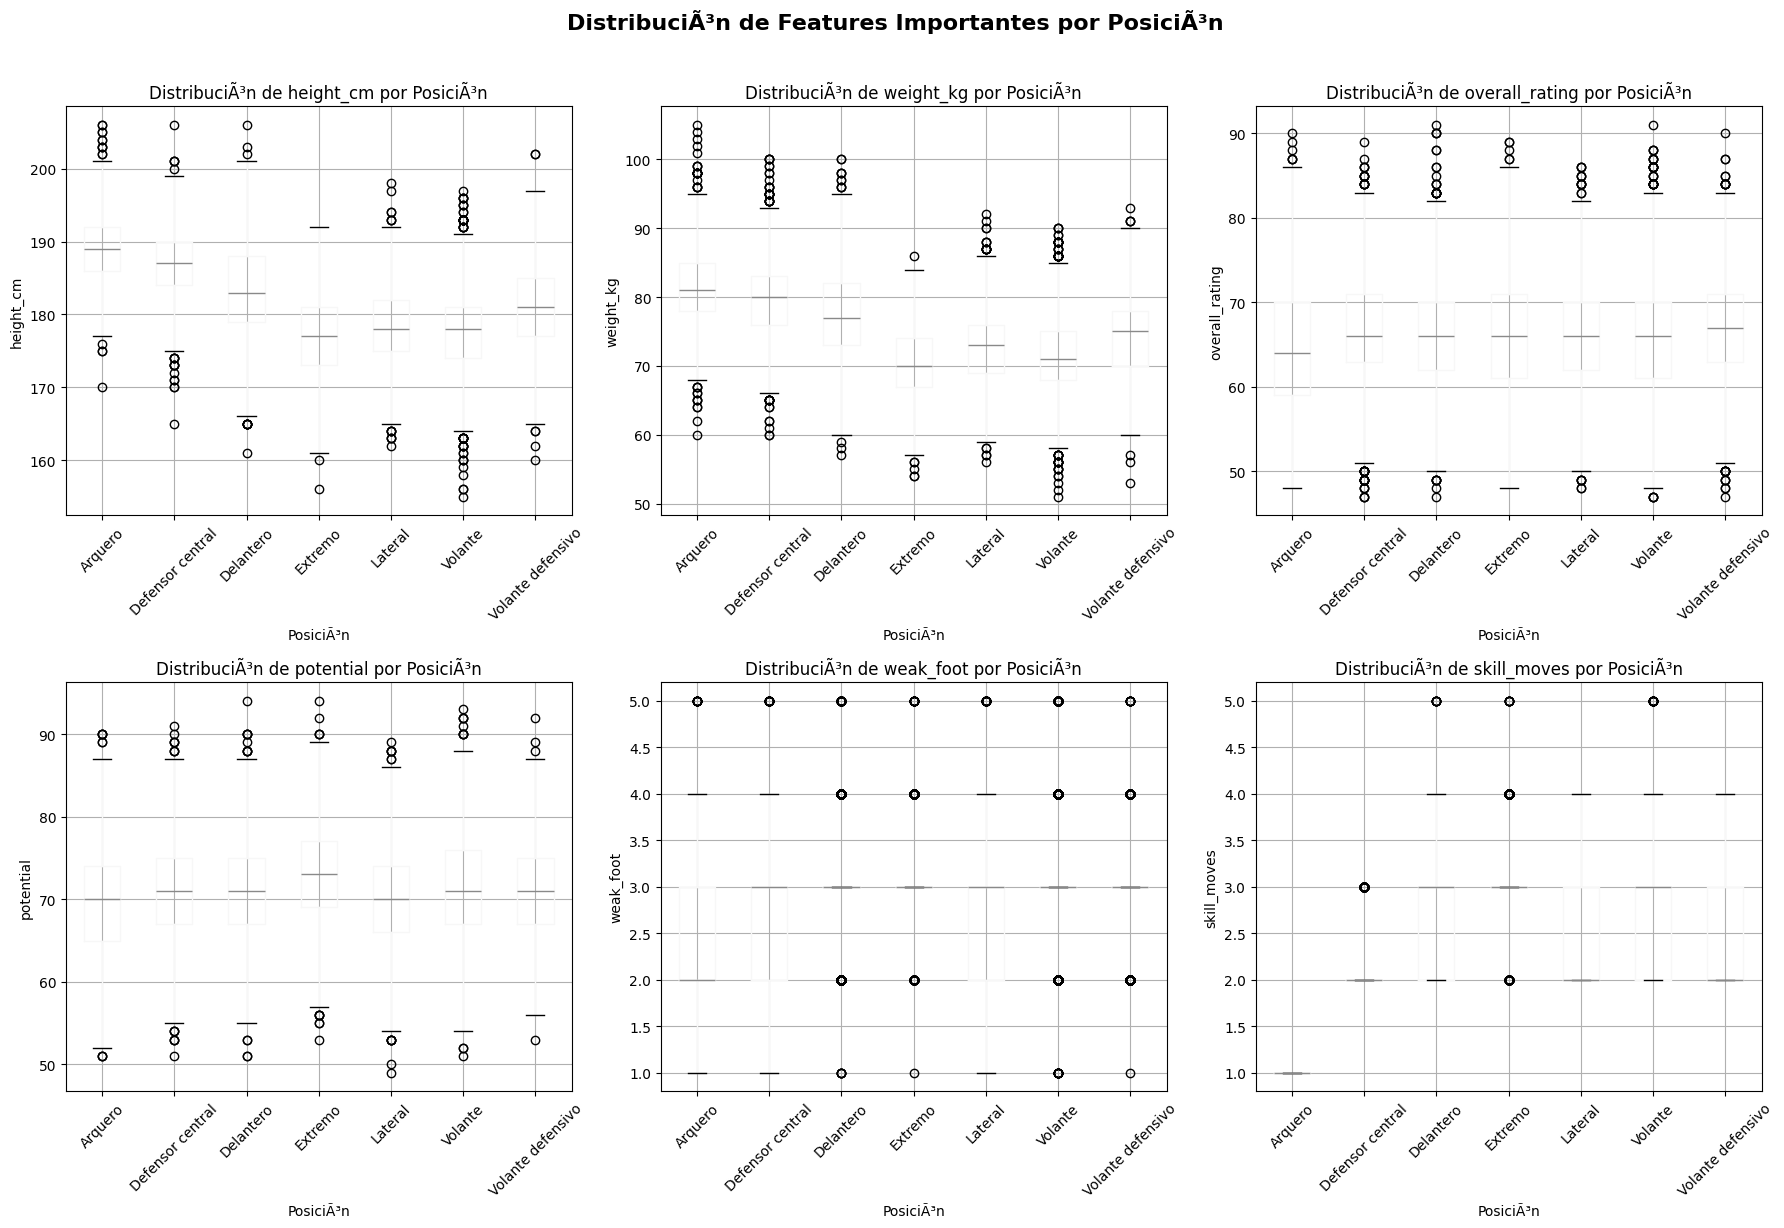

In [98]:
# AnÃ¡lisis de distribuciones por posiciÃ³n
print("ðŸ“Š ANÃLISIS DE DISTRIBUCIONES POR POSICIÃ“N")
print("=" * 45)

# Seleccionar algunas features importantes para visualizar
if hasattr(best_model.named_steps['classifier'], 'feature_importances_'):
    # Usar las features mÃ¡s importantes
    importances = best_model.named_steps['classifier'].feature_importances_
    feature_names = best_model.named_steps['selector'].selected_features_
    
    if 'feature_selection' in best_model.named_steps:
        selected_features = best_model.named_steps['feature_selection'].get_support()
        feature_names = [name for name, selected in zip(feature_names, selected_features) if selected]
    
    # Top 6 features mÃ¡s importantes
    top_features_idx = np.argsort(importances)[-6:]
    top_features = [feature_names[i] for i in top_features_idx]
else:
    # Si no hay importancia, usar features seleccionadas al azar
    feature_names = best_model.named_steps['selector'].selected_features_[:6]
    top_features = feature_names

print(f"Features seleccionadas para visualizaciÃ³n: {top_features}")

# Crear subplots para cada feature
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, feature in enumerate(top_features):
    if feature in train_df.columns:
        # Boxplot por posiciÃ³n
        train_df.boxplot(column=feature, by='posicion', ax=axes[i])
        axes[i].set_title(f'DistribuciÃ³n de {feature} por PosiciÃ³n')
        axes[i].set_xlabel('PosiciÃ³n')
        axes[i].set_ylabel(feature)
        axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.suptitle('DistribuciÃ³n de Features Importantes por PosiciÃ³n', y=1.02, fontsize=16, fontweight='bold')
plt.show()


ðŸ“Š MATRIZ DE CONFUSIÃ“N NORMALIZADA


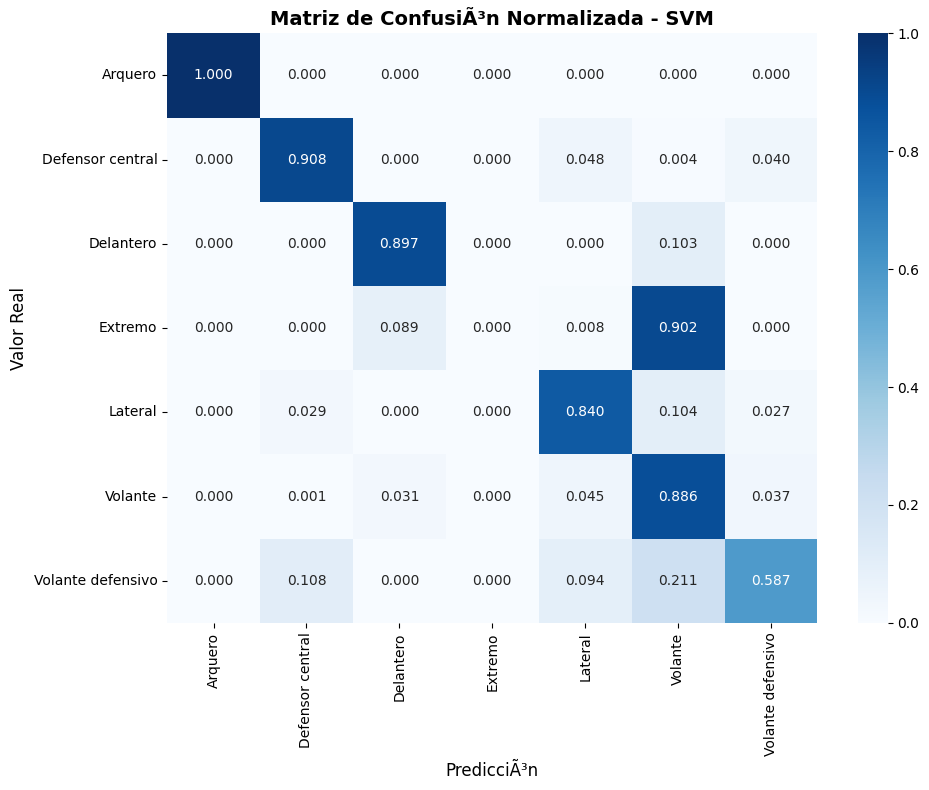


ðŸ“‹ MÃ©tricas por clase:


,PosiciÃ³n,PrecisiÃ³n,Recall,F1-Score,Support
0,Arquero,1.000,1.000,1.000,313
1,Defensor central,0.923,0.908,0.915,501
2,Delantero,0.909,0.897,0.903,399
3,Extremo,0.000,0.000,0.000,123
4,Lateral,0.819,0.840,0.829,443
5,Volante,0.743,0.886,0.808,807
6,Volante defensivo,0.679,0.587,0.630,223


In [99]:
# Matriz de confusiÃ³n normalizada
print("ðŸ“Š MATRIZ DE CONFUSIÃ“N NORMALIZADA")
print("=" * 40)

# Calcular matriz normalizada
cm_normalized = confusion_matrix(y_val, y_pred_best, normalize='true')

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues', 
            xticklabels=classes, yticklabels=classes)
plt.title(f'Matriz de ConfusiÃ³n Normalizada - {best_model_name}', fontsize=14, fontweight='bold')
plt.xlabel('PredicciÃ³n', fontsize=12)
plt.ylabel('Valor Real', fontsize=12)
plt.tight_layout()
plt.show()

# AnÃ¡lisis de precisiÃ³n y recall por clase
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(y_val, y_pred_best)

metrics_df = pd.DataFrame({
    'PosiciÃ³n': classes,
    'PrecisiÃ³n': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

print("\nðŸ“‹ MÃ©tricas por clase:")
display(metrics_df.round(3))


## 8. ðŸ“ Resumen y conclusiones

Vamos a crear un resumen final del trabajo realizado.


In [100]:
print("ðŸ“ RESUMEN FINAL DEL TRABAJO PRÃCTICO")

print(f"\nðŸŽ¯ OBJETIVO:")
print(f"   Clasificar posiciones de jugadores de FIFA usando atributos fÃ­sicos y tÃ©cnicos")

print(f"\nðŸ“Š DATASET:")
print(f"   â€¢ Entrenamiento: {train_df.shape}")
print(f"   â€¢ Test: {test_df.shape}")
print(f"   â€¢ Features seleccionadas: {len(best_model.named_steps['selector'].selected_features_)}")
print(f"   â€¢ Clases: {y.nunique()} posiciones diferentes")

print(f"\nðŸ—ï¸ PIPELINE UTILIZADO:")
print(f"   â€¢ Feature Selection: {type(best_model.named_steps['selector']).__name__}")
print(f"   â€¢ Imputation: {type(best_model.named_steps['imputer']).__name__}")
print(f"   â€¢ Scaling: {type(best_model.named_steps['scaler']).__name__}")
if 'feature_selection' in best_model.named_steps:
    print(f"   â€¢ Feature Selection: {type(best_model.named_steps['feature_selection']).__name__}")
print(f"   â€¢ Classifier: {type(best_model.named_steps['classifier']).__name__}")

print(f"\nðŸ† MEJOR MODELO: {best_model_name}")
print(f"   â€¢ Validation Accuracy: {results[best_model_name]['val_accuracy']:.4f}")
print(f"   â€¢ CV Accuracy: {results[best_model_name]['cv_mean']:.4f} (Â±{results[best_model_name]['cv_std']:.4f})")

print(f"\nðŸ“ˆ MÃ‰TRICAS DE EVALUACIÃ“N:")
print(f"   â€¢ Accuracy en validaciÃ³n: {results[best_model_name]['val_accuracy']:.4f}")
print(f"   â€¢ Matriz de confusiÃ³n: Generada y visualizada")
print(f"   â€¢ Reporte de clasificaciÃ³n: Completado")
print(f"   â€¢ ValidaciÃ³n cruzada: 5-fold implementada")

ðŸ“ RESUMEN FINAL DEL TRABAJO PRÃCTICO

ðŸŽ¯ OBJETIVO:
   Clasificar posiciones de jugadores de FIFA usando atributos fÃ­sicos y tÃ©cnicos

ðŸ“Š DATASET:
   â€¢ Entrenamiento: (14044, 49)
   â€¢ Test: (4682, 49)
   â€¢ Features seleccionadas: 40
   â€¢ Clases: 7 posiciones diferentes

ðŸ—ï¸ PIPELINE UTILIZADO:
   â€¢ Feature Selection: FeatureSelector
   â€¢ Imputation: SimpleImputer
   â€¢ Scaling: StandardScaler
   â€¢ Feature Selection: SelectKBest
   â€¢ Classifier: SVC

ðŸ† MEJOR MODELO: SVM
   â€¢ Validation Accuracy: 0.8345
   â€¢ CV Accuracy: 0.8199 (Â±0.0039)

ðŸ“ˆ MÃ‰TRICAS DE EVALUACIÃ“N:
   â€¢ Accuracy en validaciÃ³n: 0.8345
   â€¢ Matriz de confusiÃ³n: Generada y visualizada
   â€¢ Reporte de clasificaciÃ³n: Completado
   â€¢ ValidaciÃ³n cruzada: 5-fold implementada
